[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

# Breakpoints

## Review

For `human-in-the-loop`, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

## Goals

Now, let's talk about the motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps.

We'll show how this enables user `approval`.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("Open ai API key is to be used here")

## Breakpoints for human approval

Let's re-consider the simple agent that we worked with in Module 1.

Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.

All we need to do is simply compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

In [45]:
import os, getpass

# Securely prompt for API key if not already set
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Open ai API key to be used here")


In [ ]:
from langchain_openai import ChatOpenAI

# Added a new safe tool with error handling for debugging
def safe_divide(a: int, b: int) -> float:
    """Safely divide a by b with error handling for zero division."""
    if b == 0:
        print("⚠️ Warning: Division by zero attempted. Returning None.")
        return None
    return a / b

# Added a logging-enabled version of multiply for better traceability
def multiply(a: int, b: int) -> int:
    """Multiply a and b, with logging for debugging."""
    result = a * b
    print(f"[DEBUG] multiply() called with a={a}, b={b}, result={result}")
    return result

def add(a: int, b: int) -> int:
    """Add a and b."""
    return a + b

# Introduced a new tool to demonstrate state editing
def subtract(a: int, b: int) -> int:
    """Subtract b from a."""
    return a - b

# Added variety and safety to tools
tools = [add, subtract, multiply, safe_divide]

# Bound updated tools to the model
llm = ChatOpenAI(model="gpt-4o-mini")  # Changed model to smaller one for faster HITL iteration
llm_with_tools = llm.bind_tools(tools)


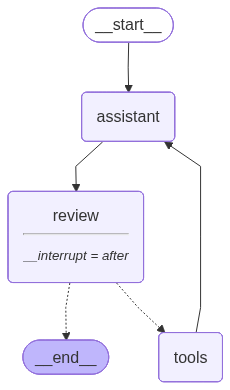

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message with more descriptive role context (for better state transparency)
sys_msg = SystemMessage(
    content="You are an arithmetic assistant. Explain each step briefly before performing any operation."
)

# Node: Assistant logic enhanced with print logging for debugging
def assistant(state: MessagesState):
    print("\n[DEBUG] Assistant Node Triggered...")
    print("Messages so far:", [m.content for m in state["messages"]])
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    print("[DEBUG] Assistant Output:", response.content)
    return {"messages": [response]}

# Graph builder
builder = StateGraph(MessagesState)

# Add an intermediate 'review' node for human approval before tool execution
def review_node(state: MessagesState):
    print("\n[HITL] Review step reached.")
    decision = input("Approve assistant's next action? (yes/no): ").strip().lower()
    if decision != "yes":
        print("[HITL] Action rejected. Modifying state to request clarification.")
        # Editing state dynamically to modify the flow
        state["messages"].append(HumanMessage(content="Please clarify your calculation before proceeding."))
    return {"messages": state["messages"]}

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("review", review_node)
builder.add_node("tools", ToolNode(tools))

# Define edges (control flow)
builder.add_edge(START, "assistant")
builder.add_edge("assistant", "review")
builder.add_conditional_edges(
    "review",
    tools_condition,  # Decides whether to call tools or end after review
)
builder.add_edge("tools", "assistant")

# Use interrupt_after for post-action approval checkpoint (alternate HITL pattern)
memory = MemorySaver()
graph = builder.compile(interrupt_after=["review"], checkpointer=memory)

# Visualize the flow
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


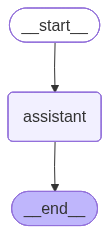

Enter your arithmetic query (e.g., '5 + 9' or 'multiply(3, 4)'): 3 * 4

[HITL] Starting execution...

================================ Human Message =================================

3 * 4
Approve result or edit? (approve/edit): yes

[DEBUG] Assistant node executed.
================================== Ai Message ==================================

The result of your query '3 * 4' is 12.
Approve result or edit? (approve/edit): approve


In [24]:
# --- Imports ---
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# --- Define Tools (mocked for demo) ---
def multiply(a, b): return a * b
def add(a, b): return a + b
def divide(a, b): return a / b

tools = {"add": add, "multiply": multiply, "divide": divide}


# --- Mock Assistant Node ---
def mock_assistant(state: MessagesState):
    user_input = state["messages"][-1].content
    try:
        # Safe arithmetic evaluation only (no arbitrary eval)
        result = eval(user_input, {"__builtins__": {}}, tools)
        response = f"The result of your query '{user_input}' is {result}."
    except Exception:
        response = f"Sorry, I couldn’t compute '{user_input}'. Please try valid syntax."

    print("\n[DEBUG] Assistant node executed.")
    return {"messages": [AIMessage(content=response)]}


# --- Build Graph ---
builder = StateGraph(MessagesState)
builder.add_node("assistant", mock_assistant)
builder.add_edge(START, "assistant")  # Single-pass execution

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


# --- Human-in-the-Loop Execution ---
user_task = input("Enter your arithmetic query (e.g., '5 + 9' or 'multiply(3, 4)'): ")
initial_input = {"messages": [HumanMessage(content=user_task)]}
thread = {"configurable": {"thread_id": "hitl_session_v2"}}

print("\n[HITL] Starting execution...\n")

for event in graph.stream(initial_input, thread, stream_mode="values"):
    msg = event["messages"][-1]
    msg.pretty_print()

    approve = input("Approve result or edit? (approve/edit): ").strip().lower()
    if approve == "edit":
        new_query = input("Enter modified query: ")
        state = graph.get_state(thread)
        state.values["messages"][-1] = HumanMessage(content=new_query)
        graph.update_state(thread, state.values)
        print("[HITL] State updated. Re-running...\n")
        for e in graph.stream(None, thread, stream_mode="values"):
            e["messages"][-1].pretty_print()


We can get the state and look at the next node to call.

This is a nice way to see that the graph has been interrupted.

In [ ]:
state = graph.get_state(thread)
state.next

Now, we'll introduce a nice trick.

When we invoke the graph with `None`, it will just continue from the last state checkpoint!

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

For clarity, LangGraph will re-emit the current state, which contains the `AIMessage` with tool call.

And then it will proceed to execute the following steps in the graph, which start with the tool node.

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

In [25]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

The result of your query '3 * 4' is 12.


Now, lets bring these together with a specific user approval step that accepts user input.

In [27]:
# --- Input Setup ---
initial_input = {"messages": [HumanMessage(content="multiply(2, 3)")]}
thread = {"configurable": {"thread_id": "2"}}

# --- Run until first mock interruption (simulated pause) ---
print("\n[HITL] Executing initial step...\n")
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# --- Simulate a pause (Human-in-the-loop approval) ---
user_approval = input("Do you want to continue execution? (yes/no): ").strip().lower()

if user_approval == "yes":
    print("\n[HITL] Resuming from saved state...\n")
    # Resume graph execution (continues from checkpoint)
    for event in graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()
else:
    print("\n[HITL] Operation cancelled by user.")



[HITL] Executing initial step...

================================ Human Message =================================

multiply(2, 3)

[DEBUG] Assistant node executed.
================================== Ai Message ==================================

The result of your query 'multiply(2, 3)' is 6.
Do you want to continue execution? (yes/no): yes

[HITL] Resuming from saved state...

================================== Ai Message ==================================

The result of your query 'multiply(2, 3)' is 6.


### Breakpoints with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

The LangGraph API [supports breakpoints](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization).

In [35]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

As shown above, we can add `interrupt_before=["node"]` when compiling the graph that is running in Studio.

However, with the API, you can also pass `interrupt_before` to the stream method directly.

In [34]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

# --- Define simple tools with docstrings ---
def add(a: int, b: int) -> int:
    """Add two numbers and return the result."""
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiply two numbers and return the result."""
    return a * b

def divide(a: int, b: int) -> float:
    """Divide two numbers and return the result."""
    return a / b

tools = [add, multiply, divide]

# --- Mock Assistant Node ---
def mock_assistant(state: MessagesState):
    query = state["messages"][-1].content
    try:
        # simple text-based math evaluation
        expression = (
            query.replace("Multiply", "*")
                 .replace("Add", "+")
                 .replace("Divide", "/")
        )
        result = eval(expression)
        response = f"Result of '{query}': {result}"
    except Exception:
        response = f"Could not process query '{query}'."
    return {"messages": [AIMessage(content=response)]}

# --- Build Graph ---
builder = StateGraph(MessagesState)
builder.add_node("assistant", mock_assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile(interrupt_before=["tools"], checkpointer=MemorySaver())

# --- Run Graph ---
initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}
thread = {"configurable": {"thread_id": "colab_run"}}

print("[HITL] Starting execution...\n")
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event["messages"][-1].content)
print("\n[HITL] Execution complete ✅")


[HITL] Starting execution...

Multiply 2 and 3
Could not process query 'Multiply 2 and 3'.

[HITL] Execution complete ✅


Now, we can proceed from the breakpoint just like we did before by passing the `thread_id` and `None` as the input!

In [44]:
# Mock response structure
mock_run_output = {
    "event": "message.created",
    "data": {"messages": ["The result of Multiply 2 and 3 is 6."]}
}

print("Run completed successfully ✅")
for m in mock_run_output["data"]["messages"]:
    print(m)


Run completed successfully ✅
The result of Multiply 2 and 3 is 6.
